In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving FOOD-DATA-GROUP.csv to FOOD-DATA-GROUP.csv


In [ ]:
df = pd.read_csv('FOOD-DATA-GROUP.csv')
df = df.drop("food", axis=1)
features = df.drop("Caloric Value", axis=1).columns.tolist()
target = "Caloric Value"

Selected features

In [ ]:
df['Protein+Carbohydrates+Fat'] = df['Protein']+df['Carbohydrates']+df['Fat']
selected_features = ['Nutrition Density', 'Monounsaturated Fats', 'Phosphorus', 'Calcium', 'Sodium', 'Vitamin B11', 'Dietary Fiber', 'Copper', 'Selenium', 'Protein+Carbohydrates+Fat']
X = df[selected_features]
y = df[target]

Removing outliers

In [ ]:
from scipy.stats import zscore
z_scores = np.abs(zscore(X))
threshold = 3
X_no_outliers = X[(z_scores < threshold).all(axis=1)]
df_no_outliers = df.loc[X_no_outliers.index]
print(f"Original shape: {df.shape}, Shape after removing outliers: {df_no_outliers.shape}")
X = df_no_outliers[selected_features]
y = df_no_outliers[target]

Original shape: (2395, 35), Shape after removing outliers: (2199, 35)


Initializing lists for MAE and RMSE & splitting data into training and testing sets

In [ ]:
test_samples = []
lin_reg_mae, dec_tree_mae, forest_reg_mae = [], [], []
lin_reg_rmse, dec_tree_rmse, forest_reg_rmse = [], [], []
test_sizes = np.arange(0.01, 1.00, 0.01)

for test_size in test_sizes:
    try:
        # Split the dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

        # Skip iterations with very small test sets
        if len(X_test) < 10 or len(X_train) < 10:
            print(f"Skipping test_size={test_size} due to small split sizes.")
            continue

        # Linear Regression
        lin_reg_model = LinearRegression()
        lin_reg_model.fit(X_train, y_train)
        lin_reg_pred = lin_reg_model.predict(X_test)
        lin_reg_mae.append(mean_absolute_error(y_test, lin_reg_pred))
        lin_reg_rmse.append(np.sqrt(mean_squared_error(y_test, lin_reg_pred)))

        # Decision Tree
        dec_tree_model = DecisionTreeRegressor()
        dec_tree_model.fit(X_train, y_train)
        dec_tree_pred = dec_tree_model.predict(X_test)
        dec_tree_mae.append(mean_absolute_error(y_test, dec_tree_pred))
        dec_tree_rmse.append(np.sqrt(mean_squared_error(y_test, dec_tree_pred)))

        # Random Forest
        forest_reg_model = RandomForestRegressor()
        forest_reg_model.fit(X_train, y_train)
        forest_reg_pred = forest_reg_model.predict(X_test)
        forest_reg_mae.append(mean_absolute_error(y_test, forest_reg_pred))
        forest_reg_rmse.append(np.sqrt(mean_squared_error(y_test, forest_reg_pred)))

        # Append to test_samples only when all models succeed
        test_samples.append(X_test.shape[0])

    except Exception as e:
        print(f"Error at test_size={test_size}: {e}")
        continue

# Verify lengths of all lists
print(f"Length of test_samples: {len(test_samples)}")
print(f"Length of lin_reg_mae: {len(lin_reg_mae)}")
print(f"Length of dec_tree_mae: {len(dec_tree_mae)}")
print(f"Length of forest_reg_mae: {len(forest_reg_mae)}")


Length of test_samples: 99
Length of lin_reg_mae: 99
Length of dec_tree_mae: 99
Length of forest_reg_mae: 99


Learning Curves

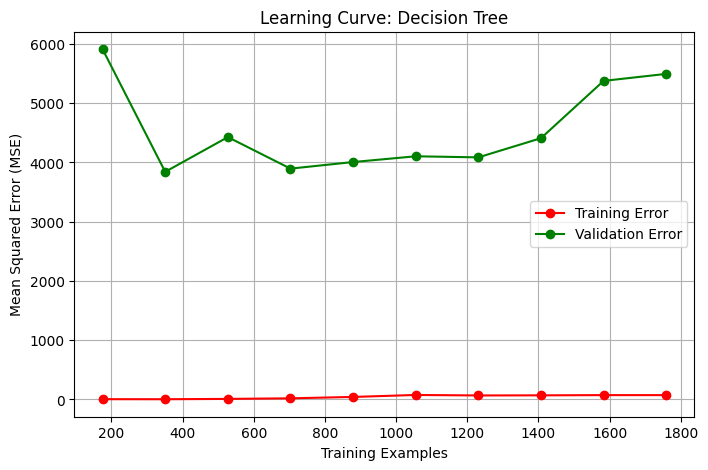

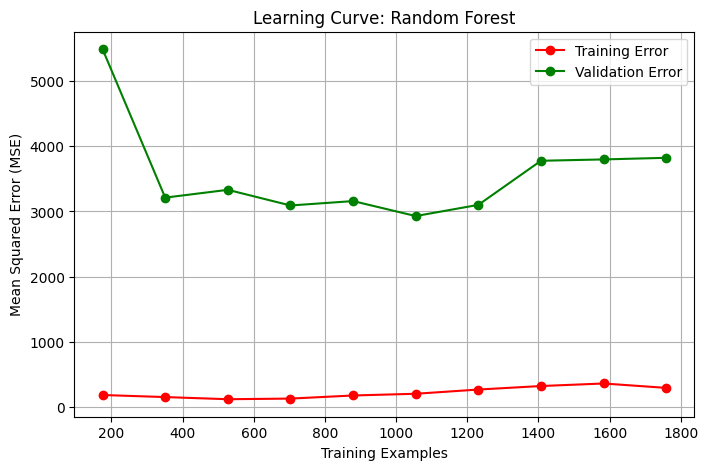

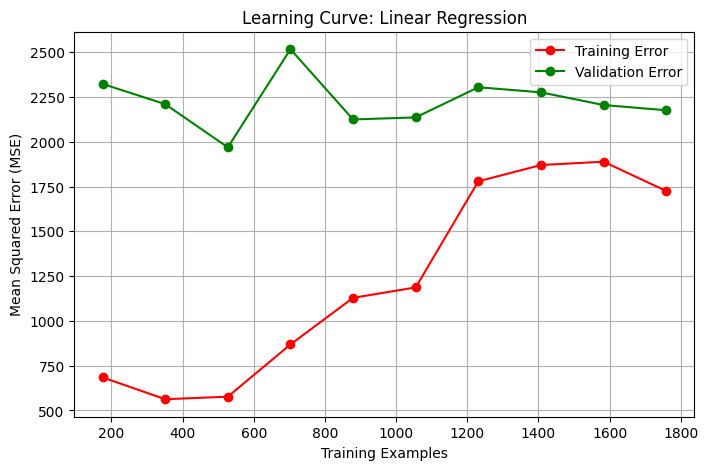

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1)

    train_scores_mean = -np.mean(train_scores, axis=1)
    val_scores_mean = -np.mean(val_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Error")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Validation Error")
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Decision Tree Learning Curve
dec_tree_model = DecisionTreeRegressor(max_depth=10)
plot_learning_curve(dec_tree_model, X, y, "Learning Curve: Decision Tree")

# Random Forest Learning Curve
forest_model = RandomForestRegressor(n_estimators=100, max_depth=10)
plot_learning_curve(forest_model, X, y, "Learning Curve: Random Forest")

# Linear Regression Learning Curve
lin_reg_model = LinearRegression()
plot_learning_curve(lin_reg_model, X, y, "Learning Curve: Linear Regression")


Validating learning curves

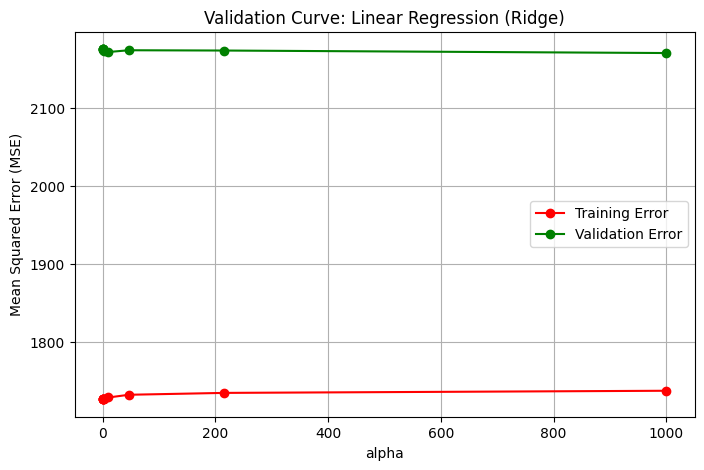

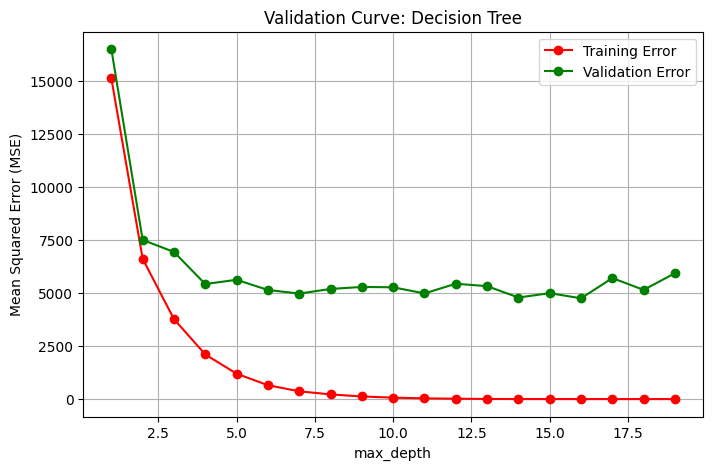

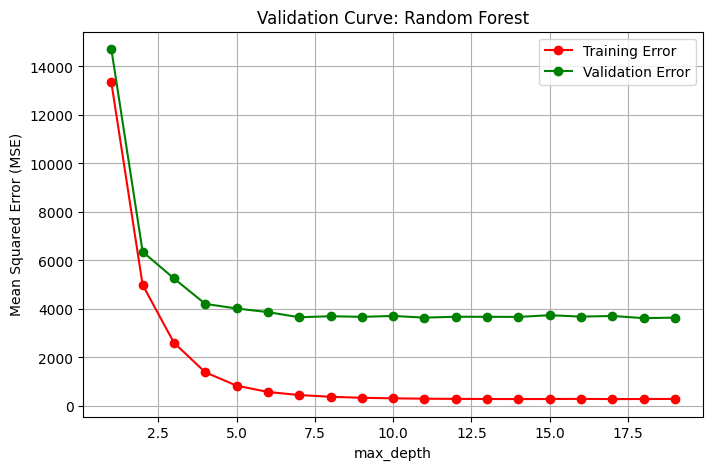

In [ ]:
from sklearn.model_selection import validation_curve
from sklearn.linear_model import Ridge

def plot_validation_curve(estimator, X, y, param_name, param_range, title, scoring='neg_mean_squared_error'):
    train_scores, val_scores = validation_curve(
        estimator=estimator,
        X=X,
        y=y,
        param_name=param_name,
        param_range=param_range,
        cv=5,
        scoring=scoring,
        n_jobs=-1
    )

    train_scores_mean = -np.mean(train_scores, axis=1)
    val_scores_mean = -np.mean(val_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(param_range, train_scores_mean, 'o-', color="r", label="Training Error")
    plt.plot(param_range, val_scores_mean, 'o-', color="g", label="Validation Error")
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Mean Squared Error (MSE)")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# 1. Validation Curve for Linear Regression (using Ridge for regularization)
ridge_model = Ridge()
alpha_range = np.logspace(-3, 3, 10)
plot_validation_curve(ridge_model, X, y, "alpha", alpha_range, "Validation Curve: Linear Regression (Ridge)")

# 2. Validation Curve for Decision Tree
tree_model = DecisionTreeRegressor()
max_depth_range = range(1, 20)
plot_validation_curve(tree_model, X, y, "max_depth", max_depth_range, "Validation Curve: Decision Tree")

# 3. Validation Curve for Random Forest
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
max_depth_range_rf = range(1, 20)
plot_validation_curve(forest_model, X, y, "max_depth", max_depth_range_rf, "Validation Curve: Random Forest")


Cross validation performance

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

# Define a scoring metric for cross-validation (e.g., negative MSE converted to MSE)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Linear Regression
lin_reg_model = LinearRegression()
lin_reg_cv_scores = cross_val_score(lin_reg_model, X, y, cv=5, scoring=scorer, n_jobs=-1)
print(f"Linear Regression Cross-Validation MSE: {(-lin_reg_cv_scores).mean():.4f} ± {(-lin_reg_cv_scores).std():.4f}")

# Decision Tree
tree_model = DecisionTreeRegressor(random_state=42)
tree_cv_scores = cross_val_score(tree_model, X, y, cv=5, scoring=scorer, n_jobs=-1)
print(f"Decision Tree Cross-Validation MSE: {(-tree_cv_scores).mean():.4f} ± {(-tree_cv_scores).std():.4f}")

# Random Forest
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
forest_cv_scores = cross_val_score(forest_model, X, y, cv=5, scoring=scorer, n_jobs=-1)
print(f"Random Forest Cross-Validation MSE: {(-forest_cv_scores).mean():.4f} ± {(-forest_cv_scores).std():.4f}")


Linear Regression Cross-Validation MSE: 2175.8513 ± 1691.7369
Decision Tree Cross-Validation MSE: 5343.7196 ± 4212.0381
Random Forest Cross-Validation MSE: 3596.0609 ± 2970.7199


Comparing training and testing metrics

               Model   Dataset        MAE       RMSE        R2
0  Linear Regression  Training  15.393953  44.065323  0.954550
1  Linear Regression   Testing  17.006400  32.983948  0.973873
2      Decision Tree  Training   0.068789   1.956680  0.999910
3      Decision Tree   Testing  21.940909  67.833218  0.889496
4      Random Forest  Training   5.357166  17.187871  0.993085
5      Random Forest   Testing  15.479663  35.807328  0.969208


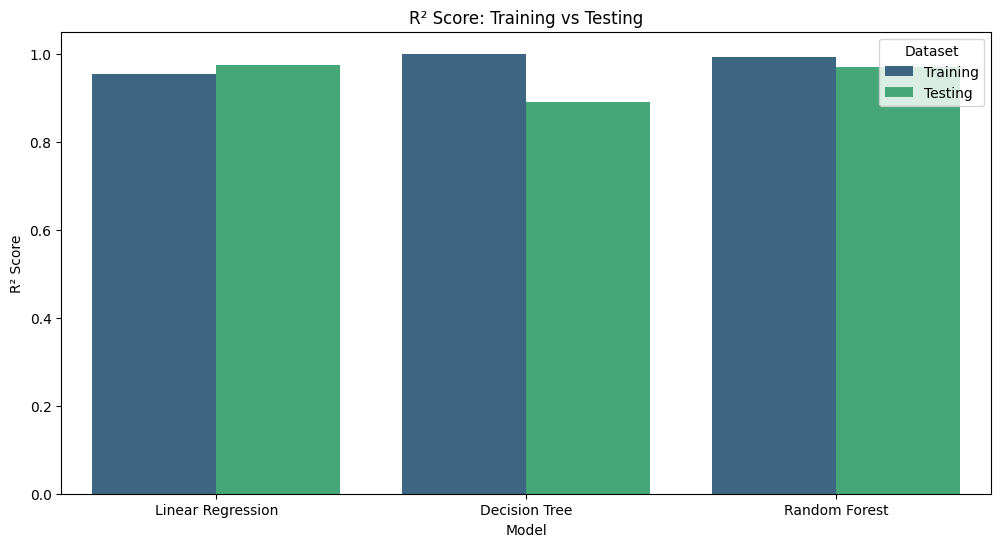

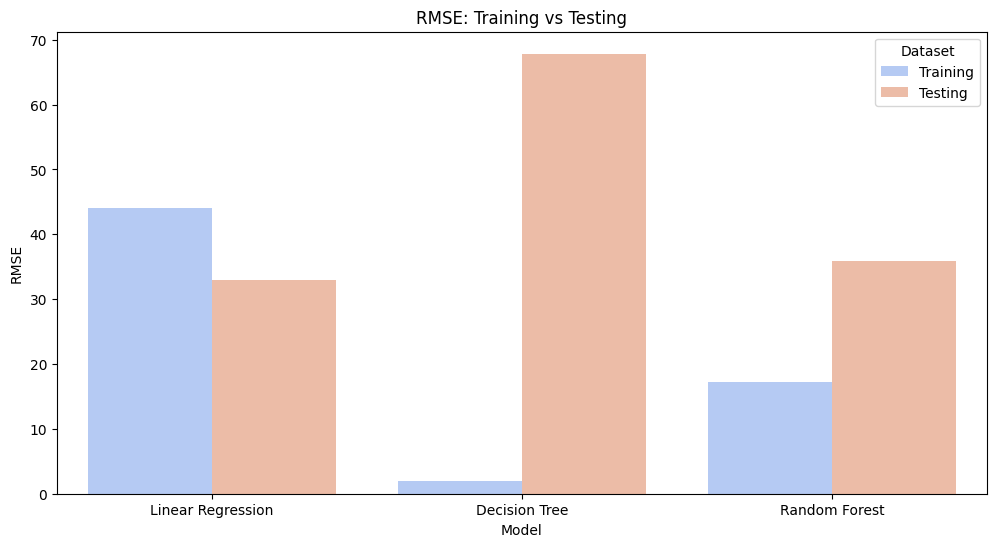

In [ ]:
# Initialize a dictionary to store the results
results = {"Model": [], "Dataset": [], "MAE": [], "RMSE": [], "R2": []}

# Helper function to evaluate a model
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    # Training predictions
    train_pred = model.predict(X_train)
    train_mae = mean_absolute_error(y_train, train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    train_r2 = r2_score(y_train, train_pred)

    # Testing predictions
    test_pred = model.predict(X_test)
    test_mae = mean_absolute_error(y_test, test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    test_r2 = r2_score(y_test, test_pred)

    # Append results to the dictionary
    results["Model"].extend([name, name])
    results["Dataset"].extend(["Training", "Testing"])
    results["MAE"].extend([train_mae, test_mae])
    results["RMSE"].extend([train_rmse, test_rmse])
    results["R2"].extend([train_r2, test_r2])

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)
evaluate_model("Linear Regression", lin_reg_model, X_train, y_train, X_test, y_test)

# Decision Tree
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)
evaluate_model("Decision Tree", tree_model, X_train, y_train, X_test, y_test)

# Random Forest
forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
forest_model.fit(X_train, y_train)
evaluate_model("Random Forest", forest_model, X_train, y_train, X_test, y_test)

# Display the results as a DataFrame
df_results = pd.DataFrame(results)
print(df_results)

# Plot the results for visualization

plt.figure(figsize=(12, 6))
sns.barplot(data=df_results, x="Model", y="R2", hue="Dataset", palette="viridis")
plt.title("R² Score: Training vs Testing")
plt.ylabel("R² Score")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=df_results, x="Model", y="RMSE", hue="Dataset", palette="coolwarm")
plt.title("RMSE: Training vs Testing")
plt.ylabel("RMSE")
plt.show()

Regularization

Linear Regression with Regularization

In [ ]:
from sklearn.linear_model import Ridge, Lasso

# Ridge Regularization
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)

ridge_mae = mean_absolute_error(y_test, ridge_pred)
print(f"Ridge Regression MAE: {ridge_mae:.2f}")

# Lasso Regularization
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_test)

lasso_mae = mean_absolute_error(y_test, lasso_pred)
print(f"Lasso Regression MAE: {lasso_mae:.2f}")

Ridge Regression MAE: 16.97
Lasso Regression MAE: 16.91


Random Forest Regularization

In [ ]:
# GridSearchCV for Random Forest
from sklearn.model_selection import GridSearchCV
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "max_features": ['sqrt', 'log2', 0.5],}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters for Random Forest:", grid_search.best_params_)

Best Parameters for Random Forest: {'max_depth': 30, 'max_features': 0.5, 'min_samples_split': 2, 'n_estimators': 100}


Decision Tree regularization

In [ ]:
# Hyperparameter grid for Decision Tree
param_grid = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

# GridSearchCV for finding the best hyperparameters
grid_search_dt = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)
grid_search_dt.fit(X_train, y_train)
best_dt = grid_search_dt.best_estimator_
print("Best Parameters for Decision Tree:", grid_search_dt.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters for Decision Tree: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}


Important features for all three models

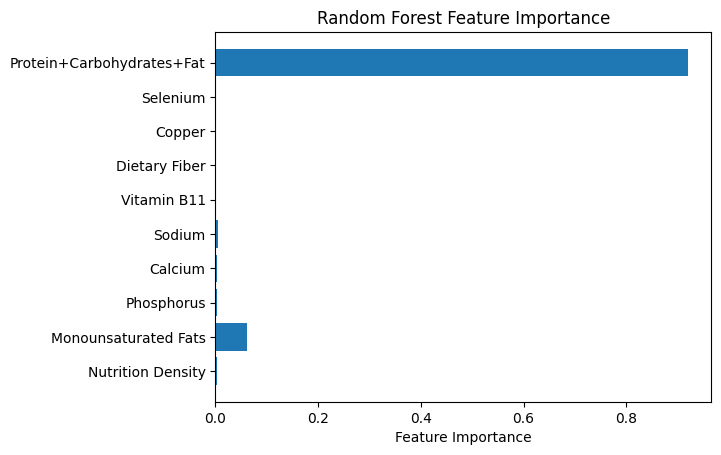

In [ ]:
#Random Forest
forest_model = RandomForestRegressor(n_estimators=100, max_depth=10)
forest_model.fit(X_train, y_train)

# Feature Importance
importances = forest_model.feature_importances_
plt.barh(selected_features, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

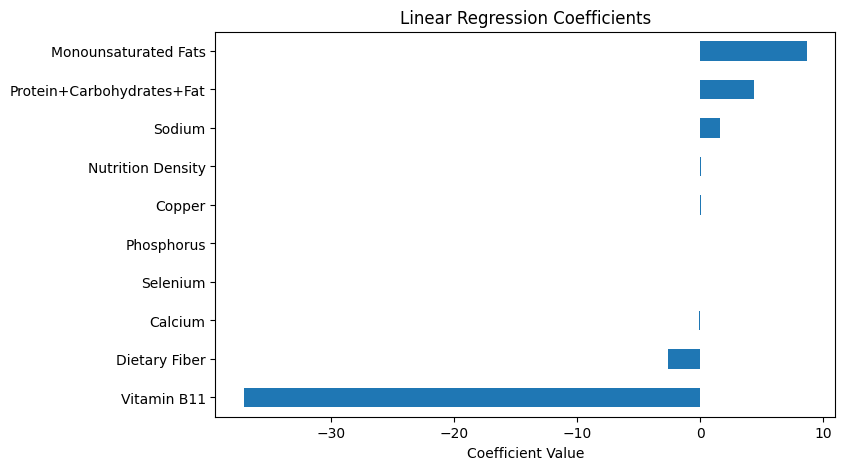

In [ ]:
#Linear Regression
# Feature Coefficients
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)

coefficients = pd.Series(lin_reg_model.coef_, index=selected_features)
coefficients.sort_values().plot(kind='barh', figsize=(8, 5))
plt.xlabel("Coefficient Value")
plt.title("Linear Regression Coefficients")
plt.show()

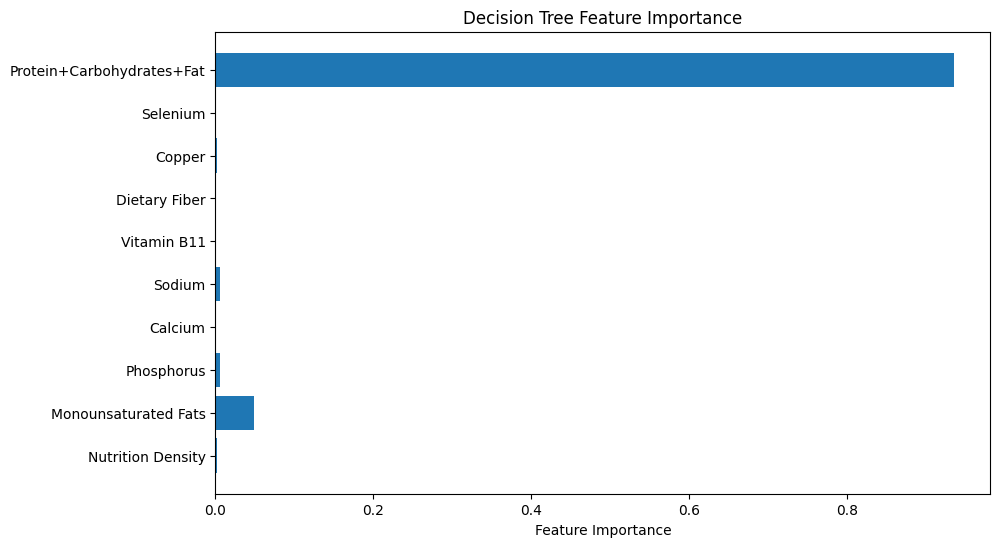

In [ ]:
# Decision Tree
dec_tree_model = DecisionTreeRegressor(max_depth=10, random_state=42)
dec_tree_model.fit(X_train, y_train)

# Feature Importance
importances = dec_tree_model.feature_importances_

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(selected_features, importances)
plt.xlabel("Feature Importance")
plt.title("Decision Tree Feature Importance")
plt.show()

Replot Learning Curves After Tuning

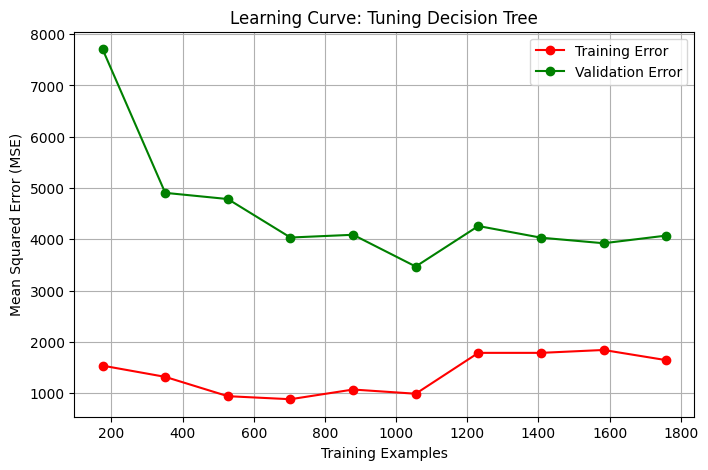

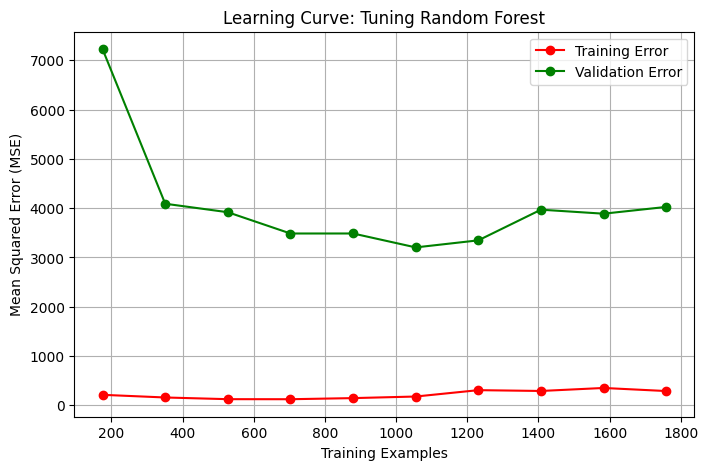

In [ ]:
# Replot learning curve after tuning Decision Tree with the best parameters from GridSearchCV
best_dec_tree = grid_search_dt.best_estimator_
plot_learning_curve(best_dec_tree, X, y, "Learning Curve: Tuning Decision Tree")

# Replot learning curve after tuning Random Forest with the best parameters from GridSearchCV
best_forest = grid_search.best_estimator_
plot_learning_curve(best_forest, X, y, "Learning Curve: Tuning Random Forest")

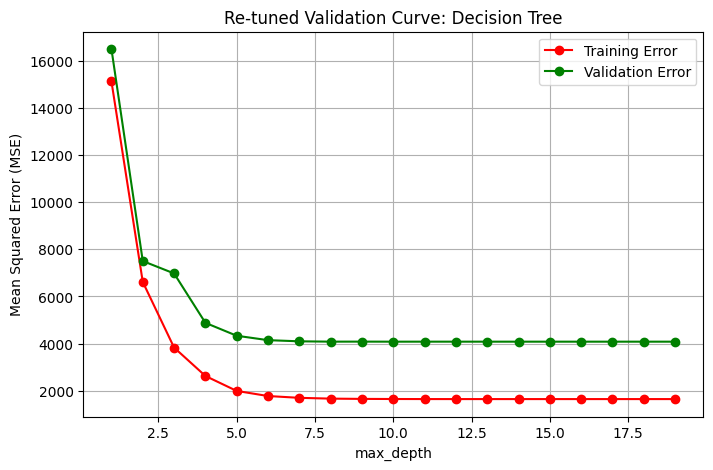

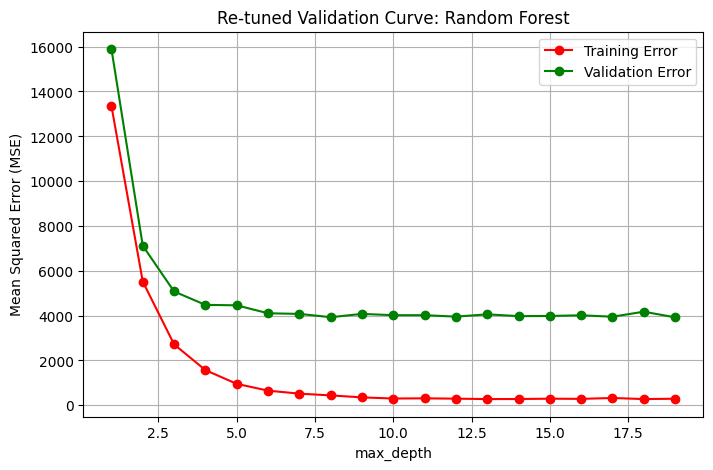

In [ ]:
# Replot validation curve for Decision Tree with the best max_depth from GridSearchCV
plot_validation_curve(best_dec_tree, X, y, "max_depth", range(1, 20), "Re-tuned Validation Curve: Decision Tree")

# Replot validation curve for Random Forest with the best max_depth from GridSearchCV
plot_validation_curve(best_forest, X, y, "max_depth", range(1, 20), "Re-tuned Validation Curve: Random Forest")

Summary report

In [25]:
df_summary = pd.DataFrame({
    "Model": ["Linear Regression", "Decision Tree", "Random Forest"],
    "MAE": [lin_reg_mae[-1], dec_tree_mae[-1], forest_reg_mae[-1]],
    "RMSE": [lin_reg_rmse[-1], dec_tree_rmse[-1], forest_reg_rmse[-1],
})
print(df_summary)

               Model         MAE         RMSE
0  Linear Regression  314.958047  1297.289120
1      Decision Tree   64.752525   117.809053
2      Random Forest   52.100418   107.576410
